In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras import metrics

data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)
# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])


In [3]:
num_data = []
## prepare dataset
for i, k in agg_by_cell:
    cell_i = agg_by_cell.get_group(i)
    # define input sequence
    series_i = cell_i['nr_people'].values
    series_i = series_i.reshape((len(series_i), 1))
    num_data.append(series_i)

In [4]:
final_data = hstack((num_data))
final_data.shape

(11808, 221)

In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 4, 6

# convert into input/output
X, y = split_sequences(final_data, n_steps_in, n_steps_out)

In [6]:
count = 0
for i in range(len(X)):
    count +=1 
    if count > 2: break
    print(X[i], y[i])

# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

[[  36.   39.   41.   41.   43.   44.   42.   41.   41.   41.   40.  446.
   373.  219.   91.   24.   25.   39.   43.   42.   43.   43.   50.   53.
    46.   41.   41.   69.  500.  382.  252.  173.   26.  124.  194.  205.
    84.   43.   43.   45.   70.   57.   56.   50.   47.  312.  394.  357.
   263.   78.  159.  320.  336.  203.  175.   68.   43.   67.   62.   58.
    58.   56.   44.   83.  147.  229.  109.  150.  187.   74.  345.  103.
   343.  122.   66.   56.   57.   58.   53.   42.   28.   23.   44.   80.
   143.   47.   41.   93.  216.  158.  181. 1166. 1306.  345.   40.   55.
    30.   25.   25.   24.   21.  213.   63.   66.  164.  218.  224.  145.
   652.  205.  426.  270.   48.   26.   24.   25.   24.   43.  233.   23.
    72.  261.   99.   91.   55.  208.  103.  614.  202.   23.   25.   24.
    24.   22.   86.  201.   65.   43.  136.  210.  136.  171.   82.   75.
    42.   25.   23.   23.   24.   24.   18.  149.  415.   26.   29.   35.
    96.  238.  256.  295.  170.  174. 

In [7]:
split_train_test = int(len(X)*0.75)
train_X, test_X = X[:split_train_test], X[split_train_test:]
train_y, test_y = y[:split_train_test], y[split_train_test:]
print(len(train_X), len(train_y), len(test_X), len(test_y))

8849 8849 2950 2950


In [8]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in,
n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu')) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse',  metrics=[metrics.mae, 'accuracy'])
# fit model
model.fit(train_X, train_y, epochs=100, verbose=2)

Epoch 1/100
 - 1s - loss: 4259.2672 - mean_absolute_error: 28.3491 - accuracy: 0.1359
Epoch 2/100
 - 1s - loss: 651.1853 - mean_absolute_error: 13.5429 - accuracy: 0.1197
Epoch 3/100
 - 1s - loss: 481.6444 - mean_absolute_error: 11.2038 - accuracy: 0.2734
Epoch 4/100
 - 1s - loss: 415.7391 - mean_absolute_error: 10.3947 - accuracy: 0.3629
Epoch 5/100
 - 1s - loss: 379.1226 - mean_absolute_error: 9.9377 - accuracy: 0.3710
Epoch 6/100
 - 1s - loss: 358.6623 - mean_absolute_error: 9.6937 - accuracy: 0.3791
Epoch 7/100
 - 1s - loss: 342.1478 - mean_absolute_error: 9.4799 - accuracy: 0.3947
Epoch 8/100
 - 1s - loss: 323.4578 - mean_absolute_error: 9.0241 - accuracy: 0.4013
Epoch 9/100
 - 1s - loss: 311.9332 - mean_absolute_error: 8.8558 - accuracy: 0.4134
Epoch 10/100
 - 1s - loss: 315.3489 - mean_absolute_error: 8.9773 - accuracy: 0.4261
Epoch 11/100
 - 1s - loss: 309.0908 - mean_absolute_error: 8.9125 - accuracy: 0.4371
Epoch 12/100
 - 1s - loss: 294.8866 - mean_absolute_error: 8.6052 - a

Epoch 98/100
 - 1s - loss: 209.5753 - mean_absolute_error: 7.1864 - accuracy: 0.5249
Epoch 99/100
 - 1s - loss: 208.0199 - mean_absolute_error: 7.1233 - accuracy: 0.5215
Epoch 100/100
 - 1s - loss: 206.7142 - mean_absolute_error: 7.1122 - accuracy: 0.5220


In [9]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0]) 


expected = test_y  
expected = np.reshape(expected, expected.shape[1] * expected.shape[0])

In [10]:
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))

Mean Absolute Error =  8.46786448386152


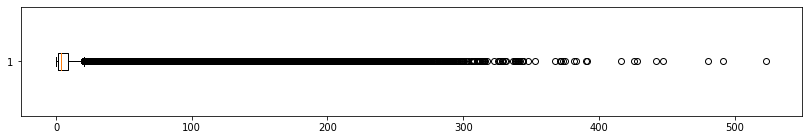

In [11]:
# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert= False);
plt.show()